In [2]:
import itertools
import os.path as op
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
import scipy.signal as sp
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import os
import pickle
import warnings
import seaborn as sns
from scipy.special import iv
from scipy.optimize import curve_fit

warnings.filterwarnings('ignore')


In [3]:
wlsubj = 139
voxels_dir = '~/mnt/winawer/Projects/Interstellar/analyses/voxels/sub-wlsubj%03d' % wlsubj
voxels_dir = os.path.expanduser(voxels_dir)
os.listdir(voxels_dir)

['sub-wlsubj139_ses-nyu3t01_task-intpilot_run-1_hemi-both.npy',
 'sub-wlsubj139_ses-nyu3t01_task-intpilot_run-2_hemi-both.npy',
 'sub-wlsubj139_ses-nyu3t01_task-intpilot_run-3_hemi-both.npy',
 'sub-wlsubj139_ses-nyu3t01_task-intpilot_run-4_hemi-both.npy',
 'sub-wlsubj139_ses-nyu3t01_task-intpilot_run-5_hemi-both.npy',
 'sub-wlsubj139_ses-nyu3t01_task-intpilot_run-6_hemi-both.npy',
 'sub-wlsubj139_voxels.npy',
 'sub-wlsubj139_voxels.tsv',
 'sub-wlsubj139_pre-voxels.tsv',
 'sub-wlsubj139_pre-voxels_subconds.tsv',
 'sub-wlsubj139_voxels_subconds.tsv']

In [110]:
prevoxels = pd.read_csv(os.path.join(voxels_dir, 'sub-wlsubj139_pre-voxels_subconds.tsv'), sep = '\t', index_col = 0)
for c in prevoxels.columns: print(c)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
x
y
eccen
angle
sigma
vexpl
angle_adj
surf_label


In [5]:
center_bin = lambda x: (x.left.astype(float) + x.right.astype(float))/2
def vonmises(theta, loc, kappa, scale):
    p = scale * np.exp(kappa*np.cos(theta-loc))/(2*np.pi*iv(0,kappa))
    return p


def diff_vonmises(theta, loc, kappa1, scale1, kappa2, scale2):
    p1 = vonmises(theta, loc, kappa1, scale1)
    p2 = vonmises(theta, loc, kappa2, scale2)
    return (p1 - p2) 


def fwhm(X, Y):
    d = Y - (np.max(Y) / 2) 
    indexes = np.where(d > 0)[0] 
    return abs(X[indexes[-1]] - X[indexes[0]])


def bin_ang_dists(voxels, angles, conds, stim_ecc = 0, subj = ''):
    df = pd.DataFrame(columns = ['subj', 'roi', 'cond', 'stim_angle', 'ang_dist', 'ang_dist_bin', 'beta', 'vexpl'])
    # Restrict Eccentricit
    if stim_ecc:
        voxels = voxels[np.abs(stim_ecc - voxels.eccen) <= voxels.sigma]
    
    # Concatenate betas by position's distance from target stims
    for i, angle in enumerate(angles):
        if not subj:
            subj = voxels['subj']
            
        df = df.append(
            pd.DataFrame(
                {'subj': subj,
                 'roi': voxels['surf_label'],
                 'ang_dist': voxels['dist_cond%02d' % i], 
                 'beta': voxels['cond%02d' % i],
                 'vexpl': voxels['vexpl'],
                 'cond': conds[i],
                 'stim_angle': angle,
                }
            ))
        
    # Bin these distances
    dist_bins = np.arange(-180, 220, 20) - 10
    bins = pd.cut(df['ang_dist'], bins=dist_bins)
    bins = bins.apply(center_bin).astype(float)
    bins[bins == -180.0] = 180.0
    df['ang_dist_bin'] = bins
    
    return df


def norm_group(voxels, yvar = 'beta', xvar = 'ang_dist_bin', group_cols = [], precision = False):
    # Take median of obs w/in each data group and distance bin
    group_cols = ['subj', 'roi', 'cond'] + group_cols
    data = voxels.groupby(group_cols + [xvar]).median()[[yvar, 'vexpl']].reset_index()
    
    if precision:
        d = voxels.groupby(group_cols + [xvar])
        prec = []
        precvar = []
        for cols, g in d:
            pwm, pwv = precision_weighted_mean(g['beta'], g['vexpl'])
            prec.append(pwm)
            precvar.append(pwv)
        
        data['prec'] = prec
        data['precvar'] = precvar
    
    # Divide each subj response by norm
    norm_data = []
    for (cols, g) in data.groupby(group_cols):
        sd = g.copy()
        sd.loc[:, 'norm'] = np.linalg.norm(sd[yvar])
        sd.loc[:, yvar+'_norm'] = sd[yvar] / sd['norm']
        sd.loc[:, 'vexpl'] = sd['vexpl']
        
        if precision:
            sd.loc[:, 'precnorm'] = np.linalg.norm(sd['prec'])
            sd.loc[:, yvar + '_precnorm'] = sd['prec'] / sd['precnorm']
            sd.loc[:, 'precvar'] = sd['precvar']
        norm_data.append(sd)
    
    norm_data = pd.concat(norm_data)
    
    # Average across subjects and multiply by average norm to get units back
    norm_data = norm_data.groupby(group_cols[1:] + [xvar]).mean().reset_index()
    norm_data[yvar+'_adj'] = norm_data[yvar+'_norm']*norm_data['norm']
    if precision: norm_data[yvar+'_adj_prec'] = norm_data[yvar+'_precnorm']*norm_data['precnorm']

    
    return norm_data
    

def fit_diff_vonmises(data, yvar, xvar = 'ang_dist_bin', group_cols=[], drop_cols=[], precision = False):
    # convert dist bins to radians
    data[xvar+'_rad'] = data[xvar].apply(np.deg2rad)
    
    # Highly sampled x range in radians
    x = np.deg2rad(np.arange(-180, 180, 1))
    
    params = []
    assumed_cols = list(filter(lambda x: x not in drop_cols, ['roi', 'cond']))
    print(assumed_cols)
    
    for cols, g in data.groupby(assumed_cols + group_cols):
        try:
            bounds = [[-np.pi, 0, 0, 0, 0], [np.pi, np.inf, np.inf, np.inf, np.inf]]
            xbin = g[xvar+'_rad'].values
            ybin = g[yvar].values
            if precision: 
                sigma = np.sqrt(g['precvar'].values)
            else:
                sigma = None
            p_opt, p_cov = curve_fit(diff_vonmises, xbin, ybin, bounds=bounds, maxfev=10000, sigma = sigma)

            y_hat = diff_vonmises(x, *p_opt)

            loc, kappa1, scale1, kappa2, scale2 = p_opt
            print(x.shape, y_hat.shape)
            width = fwhm(x, y_hat)

            # Return relevant params
            p = dict(func='diff_vonmises',
                     loc=loc,
                     loc_deg=np.rad2deg(loc),
                     kappa1=kappa1, 
                     scale1=scale1,
                     kappa2=kappa2,
                     scale2=scale2,
                     maxr=max(yhat),
                     minr=min(yhat),
                     amp=max(yhat)-min(yhat),
                     fwhm=width,
                     fwhm_deg=np.rad2deg(width)
                    )
        except:
            print("FAIL")
            p = dict()
        
        group_df = g.reset_index()[assumed_cols + group_cols].iloc[:1]
        p = pd.DataFrame(p, index=[0])
        p = pd.concat([group_df, p], axis = 1)
        params.append(p)
        
    params = pd.concat(params, sort = False).reset_index(drop=True)
    
    return params


def load_conds(pos_dir, wlsubj):
    pos_filepath = os.path.join(pos_dir, "sub-wlsubj%03d_16pos.tsv" % wlsubj)
    conds = pd.read_csv(pos_filepath, sep = "\t", index_col = 0)
    
    return conds


def precision_weighted_mean(x, var):
    x_mean = np.sum(x / var) / np.sum(1 / var)
    x_var = 1 / np.sum(1/var)

    
    return x_mean, x_var


def fix_deg(x):
    x = x - np.floor(x / 360 + 0.5) * 360
    
    return x


def convert_angle(x):
    if x < 0: x += 360
    
    return x


def norm_group(voxels, yvar = 'beta', xvar = 'ang_dist_bin', group_cols = [], precision = False):
    # Take median of obs w/in each data group and distance bin
    group_cols = ['subj', 'roi', 'task'] + group_cols
    data = voxels.groupby(group_cols + [xvar]).median()[[yvar, 'vexpl']].reset_index()
    
    if precision:
        d = voxels.groupby(group_cols + [xvar])
        prec = []
        precvar = []
        for cols, g in d:
            pwm, pwv = precision_weighted_mean(g['beta'], g['vexpl'])
            prec.append(pwm)
            precvar.append(pwv)
        
        data['prec'] = prec
        data['precvar'] = precvar
    
    # Divide each subj response by norm
    norm_data = []
    for (cols, g) in data.groupby(group_cols):
        sd = g.copy()
        sd.loc[:, 'norm'] = np.linalg.norm(sd[yvar])
        sd.loc[:, yvar+'_norm'] = sd[yvar] / sd['norm']
        sd.loc[:, 'vexpl'] = sd['vexpl']
        
        if precision:
            sd.loc[:, 'precnorm'] = np.linalg.norm(sd['prec'])
            sd.loc[:, yvar + '_precnorm'] = sd['prec'] / sd['precnorm']
            sd.loc[:, 'precvar'] = sd['precvar']
        norm_data.append(sd)
    
    norm_data = pd.concat(norm_data)
    
    # Average across subjects and multiply by average norm to get units back
    norm_data = norm_data.groupby(group_cols[1:] + [xvar]).mean().reset_index()
    norm_data[yvar+'_adj'] = norm_data[yvar+'_norm']*norm_data['norm']
    if precision: norm_data[yvar+'_adj_prec'] = norm_data[yvar+'_precnorm']*norm_data['precnorm']

    
    return norm_data

In [6]:
pos_dir = '~/mnt/winawer/Projects/Interstellar/task/Interstellar/training/positions/'
pos_dir = os.path.expanduser(pos_dir)
conditions = load_conds(pos_dir, wlsubj)

In [7]:
angles = conditions.degrees.values
tasks = conditions.task.values
conds = conditions.cond.values

In [8]:
conditions

,task,pos_x,pos_y,radians,degrees,cues,cond
0,perception,6.542560,2.488958,0.363519,20.828102,mitten04.png,0
1,perception,5.605660,4.192442,0.642152,36.792613,interlockingbuildingblock03b.png,1
2,perception,3.562709,6.025538,1.036822,59.405528,toyanimal04.png,2
3,perception,2.558828,6.515551,1.196576,68.558760,iceskate.png,3
4,perception,-0.065670,6.999692,1.580178,90.537527,medal02b.png,4
5,perception,-4.188086,5.608916,2.212172,126.748095,saintbernard.png,5
6,perception,-5.982869,3.633907,2.595760,148.726118,flyswatter.png,6
7,perception,-6.991256,0.349764,3.091606,177.135951,kangaroo.png,7
8,perception,-6.948170,-0.850258,3.263359,186.976684,rockbass.png,8
9,perception,-5.327556,-4.540611,3.847413,220.440546,fan.png,9


In [111]:

roi_data = bin_ang_dists(voxels, angles, conds, stim_ecc = 7, subj = 'wlsubj139')
norm_data = norm_group(roi_data, precision = True)

xval = 'beta_adj'
params_prec = fit_diff_vonmises(norm_data, xval, precision = True)

params_prec = params_prec.sort_values('cond', ascending = False)

theta = np.linspace(-np.pi, np.pi, 361)
fig, axs = plt.subplots(1, 2, figsize = [15, 5], sharex=True, sharey=True)
rois = voxels.surf_label.unique()



for i, row in params_prec.iterrows():
    
    ax = axs[np.where(rois == row.roi)[0][0]]
    scatter_data = norm_data.query('roi == "%s" & cond == "%s"' % (row.roi, row.cond))
    
    #ax.set_title('V%s' % row.roi)
    #vm = diff_vonmises(theta, row, row.kappa1, row.scale1, row.kappa2, row.scale2)
    
    #ax.plot(np.rad2deg(theta), vm, label = row.cond.title())
    
    
#     if row.cond == 'perception':
#         p, = ax.plot(np.rad2deg(theta), vm, label = 'Perception')
#     else:
#         n, = ax.plot(np.rad2deg(theta), vm, label = 'No Saccade')
    ax.scatter(scatter_data.ang_dist_bin, scatter_data[xval])

    
# fig.legend(handles = [s, n])

print(np.linalg.norm(norm_data['beta_adj'] - norm_data['beta_adj_prec']))

NameError: name 'voxels' is not defined

In [ ]:
params_prec

In [ ]:

plt.scatter(prevoxels.x, prevoxels.y)
plt.axis('equal')

In [ ]:
prevoxels

In [10]:
conds_by_trials

NameError: name 'conds_by_trials' is not defined

In [11]:
conds

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [12]:
glm_dir = '~/mnt/winawer/Projects/Interstellar/analyses/GLMsingle'
glm_dir = os.path.expanduser(glm_dir)
wlsubj = 139

conds_by_trials = pd.read_csv(
    os.path.join(glm_dir, "sub-wlsubj%03d" % wlsubj, "sub-wlsubj%03d_conds.tsv" % wlsubj), sep = '\t').conds.values

In [13]:
conds_by_trials

array([10, 13,  5,  2, 14,  3,  0,  8,  9, 15,  4,  1,  7, 11,  6, 12, 19,
       18, 24, 22, 27, 16, 23, 28, 21, 25, 20, 30, 29, 31, 26, 17, 42, 39,
       44, 43, 32, 33, 41, 37, 35, 34, 38, 47, 45, 46, 36, 40, 14, 11,  4,
        1,  8, 15, 12, 10,  3, 13,  7,  6,  2,  0,  9,  5, 28, 27, 31, 22,
       26, 16, 25, 21, 18, 20, 29, 19, 23, 17, 24, 30, 44, 33, 36, 43, 38,
       39, 35, 32, 47, 46, 45, 42, 40, 41, 37, 34])

In [108]:
'angle_adj' in prevoxels.columns

False

In [15]:
voxels_by_stimangle = prevoxels.filter(['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl',
       'surf_label'])

In [16]:
tasks

array(['perception', 'perception', 'perception', 'perception',
       'perception', 'perception', 'perception', 'perception',
       'perception', 'perception', 'perception', 'perception',
       'perception', 'perception', 'perception', 'perception', 'ltm',
       'ltm', 'ltm', 'ltm', 'ltm', 'ltm', 'ltm', 'ltm', 'ltm', 'ltm',
       'ltm', 'ltm', 'ltm', 'ltm', 'ltm', 'ltm', 'wm', 'wm', 'wm', 'wm',
       'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm',
       'wm'], dtype=object)

In [17]:
np.where(tasks == np.unique(tasks)[0])

(array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),)

In [107]:
pre_voxels.columns

NameError: name 'pre_voxels' is not defined

In [198]:
voxels_by_stimangle = prevoxels.filter(['x', 'y', 'eccen', 'angle', 'angle_adj', 'sigma', 'vexpl',
       'surf_label'])

voxel_dfs = {}

    
for c in conds:
    idx = np.where(new_cbt == c)[0]

    v = prevoxels.iloc[:, idx]
    v = v.mean(axis = 1)

    voxels_by_stimangle.insert(int(c), str(c), v)
    
    
for t in np.unique(tasks):
    voxel_dfs[t] = prevoxels.filter(['x', 'y', 'eccen', 'angle', 'angle_adj', 'sigma', 'vexpl',
       'surf_label'])
    voxel_dfs[t]['task'] = t
    idx = np.where(tasks == t)[0]
    print(idx)
    voxel_dfs[t] = voxel_dfs[t].merge(voxels_by_stimangle.iloc[:, idx], left_index = True, right_index = True)
    voxel_dfs[t] = voxel_dfs[t].melt(id_vars=['x', 'y', 'eccen', 'angle', 'angle_adj', 'sigma', 'vexpl', 'surf_label', 'task'], 
        var_name="condition", 
        value_name="beta")
    
    stim_angle = angles[voxel_dfs[t].condition.values.astype(int)]
    
    theta = np.asarray([convert_angle(a) for a in np.degrees(voxel_dfs[t].angle)])
    target_dist = fix_deg(theta - stim_angle)
    
    voxel_dfs[t].insert(9, 'pref_angle', theta)
    voxel_dfs[t].insert(10, 'stim_angle', stim_angle)
    voxel_dfs[t].insert(11, 'target_dist', target_dist)
    
    # Bin these distances
    dist_bins = np.arange(-180, 220, 20) - 10
    bins = pd.cut(voxel_dfs[t]['target_dist'], bins=dist_bins)
    bins = bins.apply(center_bin).astype(float)
    bins[bins == -180.0] = 180.0
    voxel_dfs[t].insert(12, 'ang_dist_bin', bins)
    
    voxel_dfs[t] = voxel_dfs[t].rename(columns = {'surf_label': 'roi'})
    voxel_dfs[t].insert(0, 'subj', 'wlsubj%03d' % wlsubj)



[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


In [199]:
interstellar = pd.concat(voxel_dfs)

In [200]:
interstellar_norm = norm_group(interstellar, precision = True)

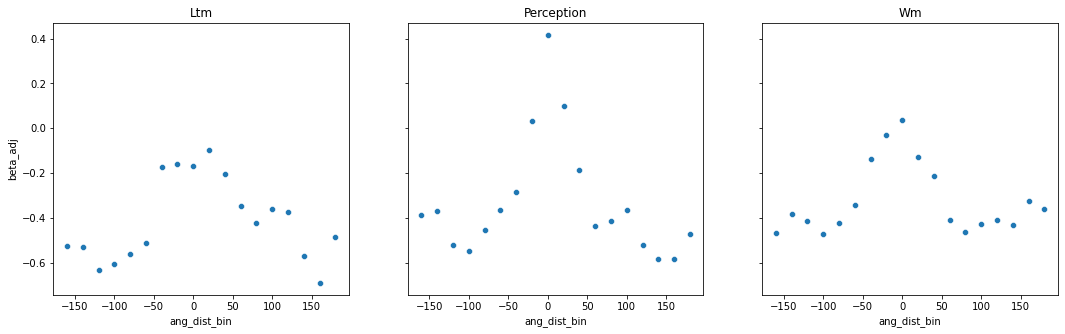

In [201]:
groups = interstellar_norm.groupby('task')
fig, axes = plt.subplots(1, interstellar_norm.task.nunique(), figsize=(18,5), sharey = True)

for i, (gname, gdata) in enumerate(groups):
    sns.scatterplot(x='ang_dist_bin', y='beta_adj', data=gdata, ax=axes[i]).set_title(gname.title())
    

In [340]:
# REDO ABOVE ANALYSES WITH LAST TRIAL IN EACH RUN EXCLUDED

In [130]:
new_cbt = np.delete(conds_by_trials, np.arange(15, 48*2, 16))
new_cbt

array([10, 13,  5,  2, 14,  3,  0,  8,  9, 15,  4,  1,  7, 11,  6, 19, 18,
       24, 22, 27, 16, 23, 28, 21, 25, 20, 30, 29, 31, 26, 42, 39, 44, 43,
       32, 33, 41, 37, 35, 34, 38, 47, 45, 46, 36, 14, 11,  4,  1,  8, 15,
       12, 10,  3, 13,  7,  6,  2,  0,  9, 28, 27, 31, 22, 26, 16, 25, 21,
       18, 20, 29, 19, 23, 17, 24, 44, 33, 36, 43, 38, 39, 35, 32, 47, 46,
       45, 42, 40, 41, 37])

In [131]:
prevoxels = pd.read_csv(os.path.join(voxels_dir, 'sub-wlsubj139_pre-voxels_subconds.tsv'), sep = '\t', index_col = 0)


In [132]:
new_cbt

array([10, 13,  5,  2, 14,  3,  0,  8,  9, 15,  4,  1,  7, 11,  6, 19, 18,
       24, 22, 27, 16, 23, 28, 21, 25, 20, 30, 29, 31, 26, 42, 39, 44, 43,
       32, 33, 41, 37, 35, 34, 38, 47, 45, 46, 36, 14, 11,  4,  1,  8, 15,
       12, 10,  3, 13,  7,  6,  2,  0,  9, 28, 27, 31, 22, 26, 16, 25, 21,
       18, 20, 29, 19, 23, 17, 24, 44, 33, 36, 43, 38, 39, 35, 32, 47, 46,
       45, 42, 40, 41, 37])

5
12
17
30
34
40
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


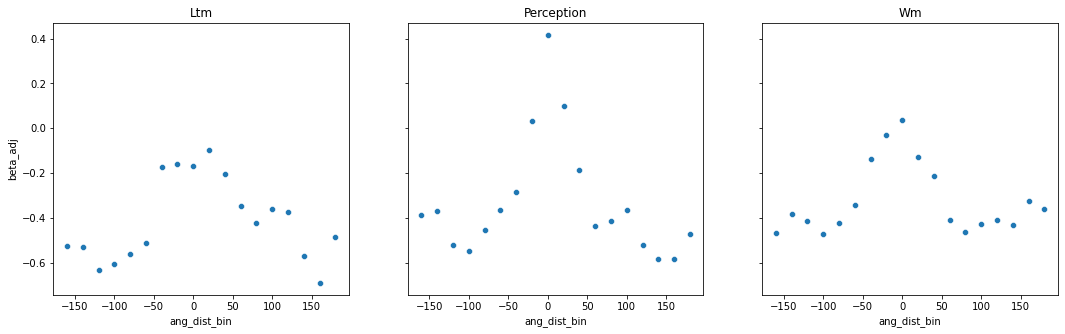

In [164]:
voxels_by_stimangle = prevoxels.filter(['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl',
       'surf_label'])

voxel_dfs = {}

    
for c in conds:
    idx = np.where(new_cbt == c)[0]
    if len(idx) == 1: print(c)
    v = prevoxels.iloc[:, idx]
    v = v.mean(axis = 1)

    voxels_by_stimangle.insert(int(c), str(c), v)
    
    
for t in np.unique(tasks):
    voxel_dfs[t] = prevoxels.filter(['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl',
       'surf_label'])
    voxel_dfs[t]['task'] = t
    idx = np.where(tasks == t)[0]
    print(idx)
    voxel_dfs[t] = voxel_dfs[t].merge(voxels_by_stimangle.iloc[:, idx], left_index = True, right_index = True)
    voxel_dfs[t] = voxel_dfs[t].melt(id_vars=['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl', 'surf_label', 'task'], 
        var_name="condition", 
        value_name="beta")
    
    stim_angle = angles[voxel_dfs[t].condition.values.astype(int)]
    
    theta = np.asarray([convert_angle(a) for a in np.degrees(voxel_dfs[t].angle)])
    
    target_dist = fix_deg(theta - stim_angle)
    
    voxel_dfs[t].insert(9, 'pref_angle', theta)
    voxel_dfs[t].insert(10, 'stim_angle', stim_angle)
    voxel_dfs[t].insert(11, 'target_dist', target_dist)
    
    # Bin these distances
    dist_bins = np.arange(-180, 220, 20) - 10
    bins = pd.cut(voxel_dfs[t]['target_dist'], bins=dist_bins)
    bins = bins.apply(center_bin).astype(float)
    bins[bins == -180.0] = 180.0
    voxel_dfs[t].insert(12, 'ang_dist_bin', bins)
    
    voxel_dfs[t] = voxel_dfs[t].rename(columns = {'surf_label': 'roi'})
    voxel_dfs[t].insert(0, 'subj', 'wlsubj%03d' % wlsubj)

interstellar = pd.concat(voxel_dfs)
interstellar_norm = norm_group(interstellar, precision = True)

groups = interstellar_norm.groupby('task')
fig, axes = plt.subplots(1, interstellar_norm.task.nunique(), figsize=(18,5), sharey = True)

for i, (gname, gdata) in enumerate(groups):
    sns.scatterplot(x='ang_dist_bin', y='beta_adj', data=gdata, ax=axes[i]).set_title(gname.title())
    
